# Prepare libraries

In [1]:
from pathlib import Path
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
from skimage import exposure
from skimage.feature import hog
import matplotlib.pyplot as plt

from utils.data_read_write import read_image, read_dataset
from utils.preprocessing import preprocess, label_to_category, preprocess
from utils.plotting import showInRow
from feature_extraction.hog import get_hog_features
from feature_extraction.bovw import BoVW
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import time
import pickle

# Parameters

In [3]:
#---------------- Data loading parameters -------------------

BOVW_TRAIN_DIR = Path("Dataset/Train_cluster")
BOVW_LABELS = "Dataset/Train_cluster/labels.csv"

TRAIN_DIR = Path("Dataset/Train")
TRAIN_LABELS_FILE = "Dataset/Train/labels.csv"

TEST_DIR = Path("Dataset/GTSRB/Final_Test/Images")
TEST_LABELS_FILE = "Dataset/GT-final_test.csv"

IMG_SIZE = (32,32)
IMG_TYPE = "ppm"

MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)


#---------------------- General -----------------------------

RANDOM_STATE = 1234


#-------------------- BoVW parametesr -----------------------

BOVW_DIR = MODELS_DIR/"BoVW"
BOVW_DIR.mkdir(exist_ok=True)

VOCABULARY_SIZE = 600
SIFT_KWARGS = {
    "contrastThreshold":0.005,
    "sigma": 1.05,
    "edgeThreshold": 50
}

CLUSTER_MODEL_SAVE_FILE = BOVW_DIR / 'kmeans_32_600.sav'
SCALER_SAVE_FILE = BOVW_DIR / 'scaler.sav'

#-------------------- HOG parameters -------------------------

HOG_KWARGS = {
    'orientations':8, 
    'pixels_per_cell':(8, 8),
    'cells_per_block':(2, 2), 
    'feature_vector': True,
    'multichannel':True,
    'block_norm':'L2'
}

#-------------------- SVM parameters -------------------------
SVM_BOVW_CLASSES_SAVE_FILE = MODELS_DIR / 'svm_bowv_classes.sav'
SVM_BOVW_CATEG_SAVE_FILE = MODELS_DIR / 'svm_bowv_categories.sav'
SVM_BOVW_KWARGS = {'kernel':'linear', 
                   'C':1, 
                   'decision_function_shape':'ovo',
                   'probability':True}

SVM_HOG_CLASSES_SAVE_FILE = MODELS_DIR / 'svm_hog_classes.sav'
SVM_HOG_CATEG_SAVE_FILE = MODELS_DIR / 'svm_hog_categories.sav'
SVM_HOG_KWARGS = {'kernel':'rbf', 
                   'C':1, 
                   'decision_function_shape':'ovr',
                   'probability':True}

# Read data

In [4]:
train_X_bovw, _ = read_dataset(images_dir=BOVW_TRAIN_DIR,
                            labels_file=BOVW_LABELS,
                             file_type=IMG_TYPE,
                             img_shape=IMG_SIZE)

train_X, train_y = read_dataset(images_dir=TRAIN_DIR,
                                labels_file=TRAIN_LABELS_FILE,
                                file_type=IMG_TYPE,
                                img_shape=IMG_SIZE)

test_X, test_y = read_dataset(images_dir=TEST_DIR,
                              labels_file=TEST_LABELS_FILE,
                              delimiter=";",
                              file_type=IMG_TYPE,
                              img_shape=IMG_SIZE)
print("Dataset size:")
print("\tTrain: ", train_X.shape[0], "images with shapes ", train_X.shape[1:])
print("\tTrain subset for BoVW: ", train_X_bovw.shape[0], "images with shapes ", train_X_bovw.shape[1:])
print("\tTest: ", test_X.shape[0], "images with shapes ", test_X.shape[1:])

Dataset size:
	Train:  22198 images with shapes  (32, 32, 3)
	Train subset for BoVW:  5106 images with shapes  (32, 32, 3)
	Test:  12630 images with shapes  (32, 32, 3)


### Convert classes to categories

In [4]:
train_categories = np.int64(train_y)
train_categories = label_to_category(train_categories)
train_categories = np.float32(train_categories)
train_y = np.float32(train_y)

# Train BoVW

In [4]:
bovw = BoVW(extractor = cv2.xfeatures2d.SIFT_create(**SIFT_KWARGS),
            train_images=train_X_bovw, 
            vocabulary_size=VOCABULARY_SIZE)

  3%|▎         | 166/5106 [00:00<00:02, 1658.23it/s]

Training BoVW starts ...
Extracting descriptors ...


  5%|▍         | 239/5105 [00:00<00:02, 2377.55it/s]

No cluster model provided, training new...
	Grouping descriptors ...


100%|██████████| 5105/5105 [00:38<00:00, 133.32it/s]


	Descriptors extracted from tarin images
	Training cluster model ...
Initialization complete
Iteration 0, inertia 15074242560.0
Iteration 1, inertia 10450312192.0
Iteration 2, inertia 10062705664.0
Iteration 3, inertia 9885586432.0
Iteration 4, inertia 9775621120.0
Iteration 5, inertia 9705049088.0
Iteration 6, inertia 9656749056.0
Iteration 7, inertia 9622064128.0
Iteration 8, inertia 9596694528.0
Iteration 9, inertia 9577444352.0
Iteration 10, inertia 9562010624.0
Iteration 11, inertia 9548982272.0
Iteration 12, inertia 9537468416.0
Iteration 13, inertia 9527559168.0
Iteration 14, inertia 9518958592.0
Iteration 15, inertia 9511973888.0
Iteration 16, inertia 9505844224.0
Iteration 17, inertia 9500535808.0
Iteration 18, inertia 9496170496.0
Iteration 19, inertia 9492355072.0
Iteration 20, inertia 9489401856.0
Iteration 21, inertia 9486584832.0
Iteration 22, inertia 9483935744.0
Iteration 23, inertia 9481365504.0
Iteration 24, inertia 9479192576.0
Iteration 25, inertia 9477392384.0
Iter

  0%|          | 8/5106 [00:00<01:06, 77.12it/s]

Iteration 147, inertia 9446394880.0
Converged at iteration 147: strict convergence.
	Cluster model trained
Computing histograms ...


100%|██████████| 5106/5106 [00:45<00:00, 111.23it/s]

Histograms computed
Normalizing histograms ...
Histograms normalized


In [5]:
bovw.save(CLUSTER_MODEL_SAVE_FILE, SCALER_SAVE_FILE)

# Check nearest neighbours

100%|██████████| 1/1 [00:00<00:00, 95.95it/s]


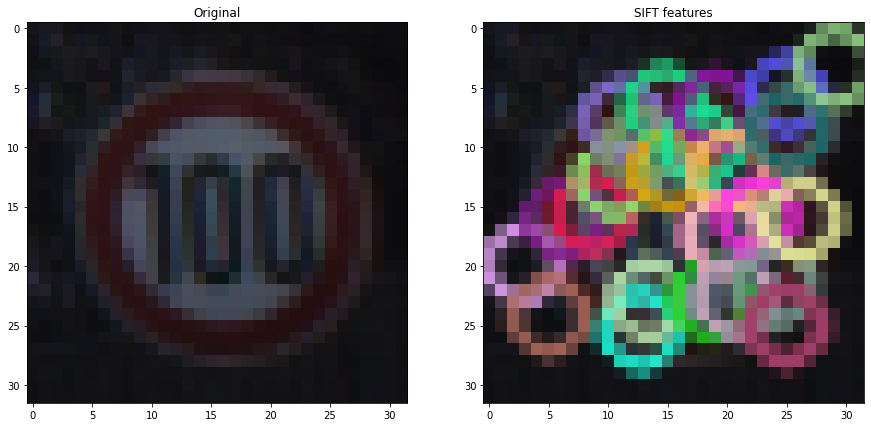

Nearest Neighbours with distances:


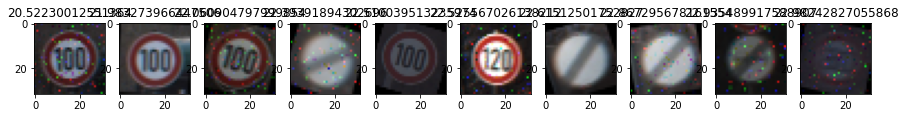

(array([[20.52230013, 21.98327397, 22.0609048 , 22.39391894, 22.51003951,
         22.52556703, 22.61512502, 22.86729568, 22.93548992, 22.98242827]]),
 array([[3262, 2309,  905, 4431, 3227, 4740, 3143, 4966, 4858, 4029]]))

In [25]:
test_img = test_X[6]
bovw.get_nearest_neighbours(test_img, n_neighbours=10, display=True)


# Train Linear SVM for BoVW features

### Get features of training dataset

In [11]:
start_t = time.time()
train_features = bovw.get_features(train_X)
train_features = np.float32(train_features).reshape(len(train_features),-1)
end_t = time.time()
print("Time taken: ", end_t-start_t)

  1%|          | 153/22198 [00:00<00:14, 1522.10it/s]

Extracting descriptors ...


  0%|          | 11/22198 [00:00<03:29, 105.76it/s]

Computing histograms ...


100%|██████████| 22198/22198 [03:28<00:00, 106.64it/s]

Normalizing histograms ...
Done
Time taken:  220.56960153579712


In [65]:
print("BoVW features shape: ", train_features[0].shape)

BiVW features shape:  (600,)


## Case 1: Learn classes separately

### Train SVM

In [13]:
start_t = time.time()
svm_bovw_classes = SVC(**SVM_BOVW_KWARGS).fit(train_features, train_y)
end_t = time.time()
print("Time taken: ", end_t-start_t)

Time taken:  642.3388938903809


### Save Model

In [23]:
with open(SVM_BOVW_CLASSES_SAVE_FILE, 'wb') as save_file:
    pickle.dump(svm, save_file)

## Case 2: Learn categories of classes

### Train SVM

In [25]:
start_t = time.time()
svm_bovw_categ = SVC(**SVM_BOVW_KWARGS).fit(train_features, train_categories)
end_t = time.time()
print("Time taken: ", end_t-start_t)

Time taken:  265.60935735702515


### Save Model

In [26]:
with open(SVM_BOVW_CATEG_SAVE_FILE, 'wb') as save_file:
    pickle.dump(svm_bovw_categ, save_file)


---
# Train HOG

### Get Train features with HOG

In [27]:
start_t = time.time()
train_hog_features = get_hog_features(train_X, **HOG_KWARGS)
end_t = time.time()
print("Time taken: ", end_t-start_t)

 27%|██▋       | 6095/22198 [00:02<00:07, 2173.91it/s]


KeyboardInterrupt: 

In [76]:
print("HOG features shape: ", train_hog_features[0].shape)

HOG features shape:  (288,)


## Case 1: Learn classes separately

In [77]:
start_t = time.time()
svm_hog_classes = SVC(**SVM_HOG_KWARGS).fit(train_hog_features, train_y)
end_t = time.time()
print("Time taken: ", end_t-start_t)

Time taken:  413.20162892341614


### Save model

In [78]:
with open(SVM_HOG_CLASSES_SAVE_FILE, 'wb') as save_file:
    pickle.dump(svm_hog_classes, save_file)

## Case 2: Learn categories of classes

In [79]:
start_t = time.time()
svm_hog_categories = SVC(**SVM_HOG_KWARGS).fit(train_hog_features, train_categories)
end_t = time.time()
print("Time taken: ", end_t-start_t)

Time taken:  205.62784790992737


### Save model

In [80]:
with open(SVM_HOG_CATEG_SAVE_FILE, 'wb') as save_file:
    pickle.dump(svm_hog_categories, save_file)

# Additionally: Visualise features

## Visualise SIFT

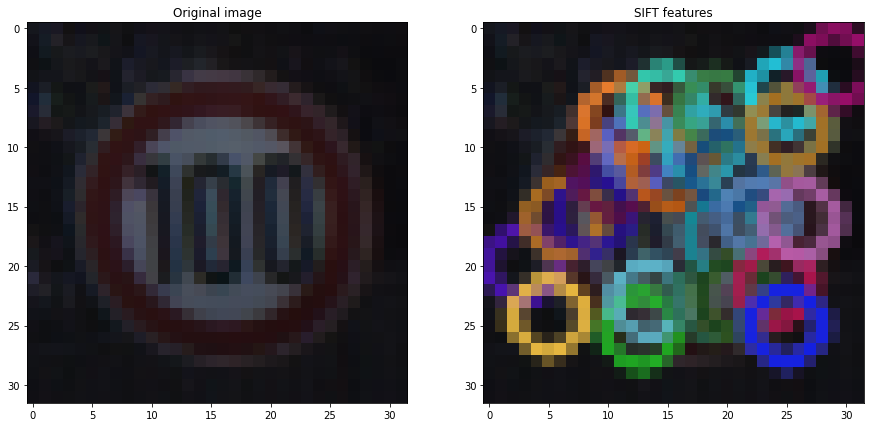

In [81]:
test_img = test_X[6]
keypoints, descriptors = cv2.xfeatures2d.SIFT_create(**SIFT_KWARGS).detectAndCompute(test_img, None)
showInRow([test_img, cv2.drawKeypoints(test_img, keypoints, test_img.copy())],["Original image", "SIFT features"])

## Visualise HOG

(288,)


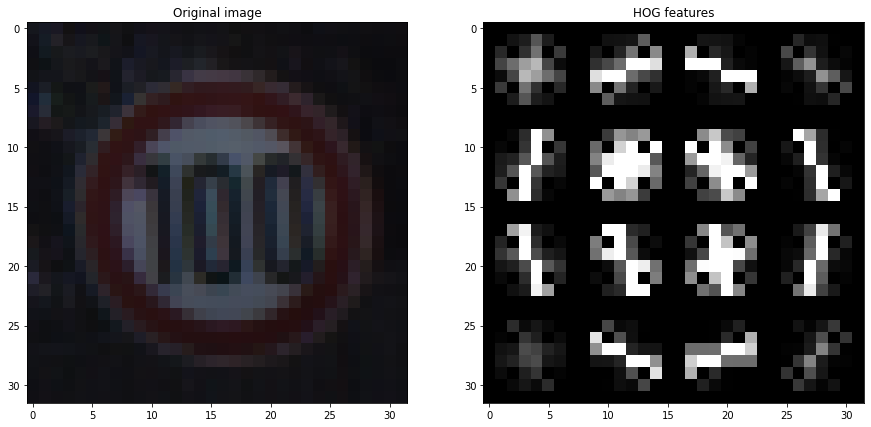

In [82]:
test_img = test_X[6]
fd, hog_image = hog(test_img, visualize=True, **HOG_KWARGS)
print(fd.shape)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
showInRow([test_img, hog_image_rescaled], ["Original image", "HOG features"])